In [1]:
%matplotlib inline

In [57]:
cp.installed_solvers()

['ECOS', 'ECOS_BB', 'GUROBI', 'MOSEK', 'OSQP', 'SCIP', 'SCIPY', 'SCS']

In [2]:
#import matplotlib
#matplotlib.use("pgf")

In [3]:
import math 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.optimize import brentq

import cvxpy as cp

from tqdm.notebook import trange

In [4]:
from rsnn.spike_train.generator import PeriodicSpikeTrainGenerator
from rsnn.spike_train.spike_train import SpikeTrain
from rsnn.spike_train.periodic_spike_train import MultiChannelPeriodicSpikeTrain
from rsnn.rsnn.neuron import Neuron
from rsnn.spike_train.measure import single_channel_correlation

/Users/haguettaz/Documents/RSNN/src/rsnn/spike_train/generator.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [5]:
plt.style.use('paper')

In [6]:
rng = np.random.default_rng(7)

# Supervised Learning for Spiking Neurons

In [165]:
num_inputs = 1000 # number of synapses
delays = rng.uniform(1.0, 20.0, num_inputs)

kernel_decay = 10

firing_threshold = 1.0
wmin, wmax = -0.1, 0.1

period = 500.0
firing_rate, rel_refractory_period, abs_refractory_period = 0.1, 5.0, 5.0
refractory_weight = 1

In [135]:
times = np.linspace(0, period, 10000)

In [160]:
def input_spike_resp(t):
        
    #tmax = (math.log(synapse_beta) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_beta)
    #gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_beta))

    if isinstance(t, np.ndarray):
        #z = gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_beta))
        z = t / 5 * np.exp(1 - t / 5)
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    #return gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_beta))
    return t / 5 * np.exp(1 - t / 5)
    
def input_spike_resp_deriv(t):
    tmax = (math.log(synapse_beta) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_beta)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_beta))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / synapse_beta) / synapse_beta - np.exp(-t / soma_decay) / soma_decay)
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / synapse_beta) / synapse_beta - np.exp(-t / soma_decay) / soma_decay)

def refractory_spike_resp(t):
    if isinstance(t, np.ndarray):
        z = -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = -np.inf
        z[t <= 0] = 0.0
        return z
    
    if t <= 0:
        return 0.0
    
    if t <= abs_refractory_period:
        return -np.inf
    
    return -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)

def refractory_spike_resp_deriv(t):
    if isinstance(t, np.ndarray):
        z = refractory_weight / soma_decay * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = 0.0
        return z

    if t <= abs_refractory_period:
        return 0.0
    
    return refractory_weight / soma_decay * np.exp(- (t - abs_refractory_period) / soma_decay)

In [161]:
def potential(t, delays, weights, input_spike_trains, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo:
            y = np.array([
                np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])%period), axis=0) for k in range(num_inputs)
            ])
            return weights@y
        
        y = np.array([
            np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])), axis=0) for k in range(num_inputs)
        ])
        return weights@y  
        
    if modulo:
        y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)%period), axis=0) for k in range(num_inputs)
        ])
        return weights@y
    
    y = np.array([
        np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)), axis=0) for k in range(num_inputs)
    ])
    return weights@y  

def potential_deriv(t, delays, weights, input_spike_trains, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo:
            y = np.array([
                np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])%period), axis=0) for k in range(num_inputs)
                ])
            return weights@y
        
        y = np.array([
                np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])), axis=0) for k in range(num_inputs)
            ])
        return weights@y
    
    if modulo:
        y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)%period), axis=0) for k in range(num_inputs)
            ])
        return weights@y  
    
    y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)), axis=0) for k in range(num_inputs)
        ])
    return weights@y

def threshold(t, target_spike_train, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo: 
            return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])%period), axis=0)

        return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])), axis=0)
    
    if modulo: 
        return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times)%period), axis=0)        
    return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times)), axis=0)

In [195]:
1.0 + np.exp(-((0 - 53.55974238 - 5.0) % 100)/5.0)

1.0002515040352051

In [162]:
#def threshold(t, target_spike_train, modulo=True):
#    if isinstance(t, np.ndarray):
#        if modulo: 
#            return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])%period), axis=0)
#
#        return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])), axis=0)
#    
#    if modulo: 
#        return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times[:,None])%period), axis=0)        
#    return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times[:,None])), axis=0)

In [163]:
#def threshold_deriv(t, target_spike_train):
#    if isinstance(t, np.ndarray):
#        return - np.sum(refractory_spike_resp_deriv((t[None,:] - target_spike_train.firing_times[:,None])), axis=0)
#    return - np.sum(refractory_spike_resp_deriv((t - target_spike_train.firing_times[:,None])), axis=0)

In [188]:
input_spike_resp((0 - 92.17851908 - 1)%100)

0.9477566533512751

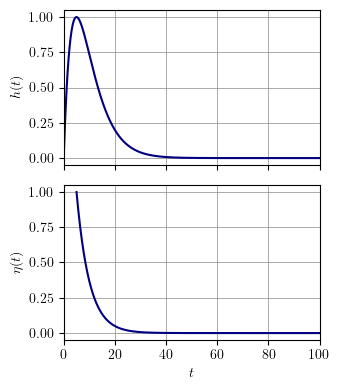

In [164]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.5, 4))

times = np.linspace(0, 100, 1000)

axes[0].plot(times, input_spike_resp(times), c="C2", label=r"$g_0 * g_k$")
axes[1].plot(times, -refractory_spike_resp(times), c="C2", label=r"$-g_0$")
#axes[0].legend()
#axes[1].legend()
#axes[0].set_xlabel(r"$t$")
#axes[0].set_xlim(0, period)
axes[0].set_ylabel(r"$h(t)$")
axes[1].set_ylabel(r"$\eta(t)$")
axes[1].set_xlabel(r"$t$")
axes[1].set_xlim(0, 100)

fig.tight_layout()
fig.savefig('spike_responses.pgf')
#plt.show()

In [141]:
spike_train_generator = PeriodicSpikeTrainGenerator(firing_rate, abs_refractory_period, rel_refractory_period)

In [142]:
input_spike_trains = spike_train_generator.rand(period, num_inputs)
#input_spike_train = spike_train_generator.rand(period)
#input_spike_trains = MultiChannelPeriodicSpikeTrain(
#    period, 
#    num_inputs,
#    [input_spike_train.firing_times]*num_inputs
#)
target_spike_train = spike_train_generator.rand(period)

Multi-channel periodic spike train sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

In [143]:
num_spikes = np.array([spike_train.num_spikes for spike_train in input_spike_trains.spike_trains])

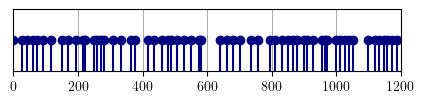

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(5, 0.8))
ax.stem(target_spike_train.firing_times, np.ones_like(target_spike_train.firing_times), basefmt=" ", markerfmt="C2o", linefmt="C2-")
ax.set_xlim(0, period)
ax.set_ylim(0, 2)
ax.set_yticks([])
plt.show()

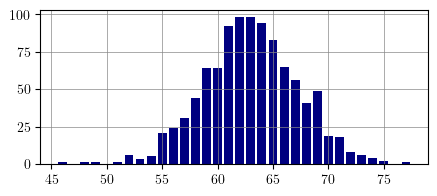

In [145]:
unique, counts = np.unique(num_spikes, return_counts=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
ax.bar(unique, counts, color="C2")
#ax.set_xticks(np.arange(np.min(num_spikes), np.max(num_spikes)+1))
plt.show()

In [146]:
delays = rng.uniform(1.0, 60.0, num_inputs)

# Computing Weights

In [147]:
def compute_spike_train(weights):
    spike_train = target_spike_train.copy()
    
    fun = lambda t_: potential(t_, delays, weights, input_spike_trains) - threshold(t_, spike_train, modulo=False)

    ta = spike_train.firing_times[-1] + abs_refractory_period
    while(ta < 2*period):
        tb = ta + 1
        if fun(ta) * fun(tb) <= 0:
            t = brentq(fun, ta, tb)
            spike_train.append(t)
            ta += abs_refractory_period
        else:
            ta += 1

    return spike_train

In [148]:
extended_firing_times = np.concatenate([
    target_spike_train.firing_times - period,
    target_spike_train.firing_times,
    target_spike_train.firing_times + period
])

times = np.arange(0, period, 1e-2)
time_diff = times[:,None] - extended_firing_times[None,:]
mask_slope = np.any(np.abs(time_diff) < 1.0, axis=1)
t_slope = times[mask_slope]
y_slope = np.stack(
    [np.sum(
        input_spike_resp_deriv(
            (t_slope[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_slope = np.full_like(t_slope, 0.5)

times = np.arange(0, period, 1e-2)
time_diff = times[:,None] - extended_firing_times[None,:]
mask_level_f = np.any((time_diff > -1.0) & (time_diff < 0.0), axis=1)
t_level_f = times[mask_level_f]
y_level_f = np.stack(
    [np.sum(
        input_spike_resp(
            (t_level_f[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_level_f = firing_threshold - np.sum(
    refractory_spike_resp(
        (t_level_f[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

times = np.arange(0, period, 1e-1)
time_diff = times[:,None] - extended_firing_times[None,:]
mask_level = np.all((time_diff > abs_refractory_period) | (time_diff < -1.0), axis=1)
t_level = times[mask_level]
y_level = np.stack(
    [np.sum(
        input_spike_resp(
            (t_level[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_level = 0.0 - np.sum(
    refractory_spike_resp(
        (t_level[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

y_firing = np.stack(
    [np.sum(
        input_spike_resp(
            (target_spike_train.firing_times[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_firing = firing_threshold - np.sum(
    refractory_spike_resp(
        (target_spike_train.firing_times[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

## Bounded Weights

In [149]:
weights = cp.Variable(num_inputs)
objective = cp.Minimize(0.0)
constraints = [
    y_firing @ weights == z_firing, 
    y_level_f @ weights <= z_level_f, 
    y_level @ weights <= z_level, 
    y_slope @ weights >= z_slope,
    weights >= wmin,
    weights <= wmax
]
prob = cp.Problem(objective, constraints)

In [150]:
_ = prob.solve(solver="GUROBI")
print("problem is", prob.status)

problem is infeasible


AxisError: axis -1 is out of bounds for array of dimension 0

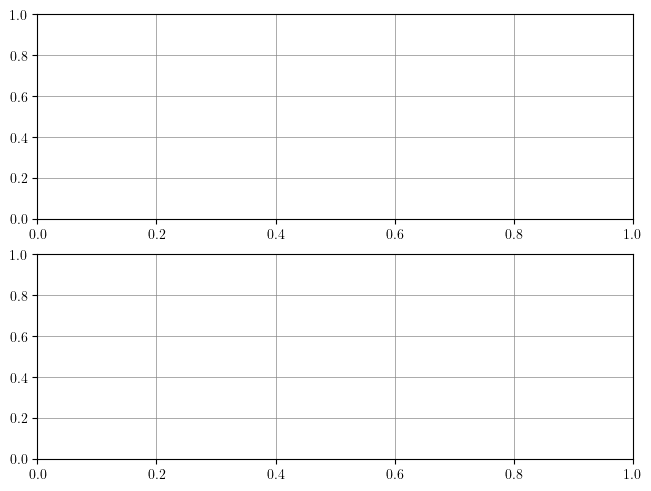

In [151]:
times = np.linspace(0, period, 1000)

fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), np.sort(weights.value), s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_ylim(wmin, wmax)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
#_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
#_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C0")
_ = axes_template[1].plot(times, potential(times, delays, weights.value, input_spike_trains), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

In [ ]:
spike_train = compute_spike_train(weights.value)
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(weights.value)/num_inputs:.6f}")
print(f"energy: {np.sum(np.square(weights.value))/num_inputs:.6f}")

## Bounded Weights with L2 Regularization

In [37]:
weights_r2 = cp.Variable(num_inputs)
objective = cp.Minimize(cp.norm2(weights_r2))
constraints = [
    y_firing @ weights_r2 == z_firing, 
    y_level_f @ weights_r2 <= z_level_f, 
    y_level @ weights_r2 <= z_level, 
    y_slope @ weights_r2 >= z_slope,
    weights_r2 >= wmin,
    weights_r2 <= wmax
]
prob = cp.Problem(objective, constraints)

In [38]:
_ = prob.solve(solver="GUROBI")
print("problem is", prob.status)

SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
times = np.linspace(0, period, 1000)

fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), np.sort(weights_r2.value), s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_ylim(wmin, wmax)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
#_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
#_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C0")
_ = axes_template[1].plot(times, potential(times, delays, weights_r2.value, input_spike_trains), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

In [ ]:
spike_train = compute_spike_train(weights.value)
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(weights.value)/num_inputs:.6f}")
print(f"energy: {np.sum(np.square(weights.value))/num_inputs:.6f}")

## Bounded Weights with L1 Regularization

In [39]:
weights_r1 = cp.Variable(num_inputs)
objective = cp.Minimize(cp.norm1(weights_r1))
constraints = [
    y_firing @ weights_r1 == z_firing, 
    y_level_f @ weights_r1 <= z_level_f, 
    y_level @ weights_r1 <= z_level, 
    y_slope @ weights_r1 >= z_slope,
    weights_r1 >= wmin,
    weights_r1 <= wmax
]
prob = cp.Problem(objective, constraints)

In [40]:
_ = prob.solve(solver="GUROBI")
print("problem is", prob.status)

problem is optimal


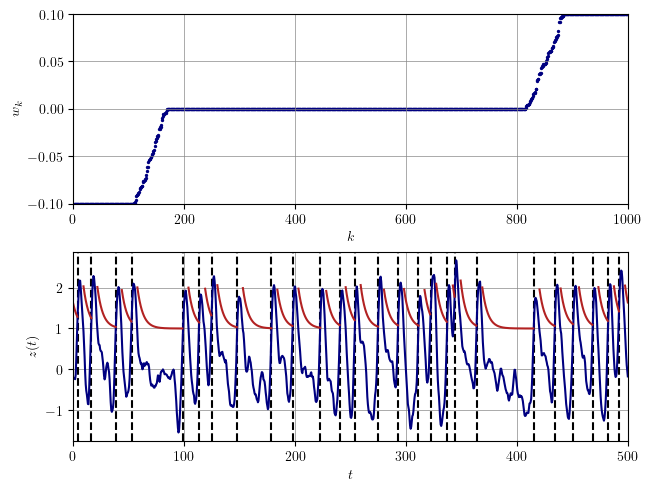

In [41]:
times = np.linspace(0, period, 1000)

fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), np.sort(weights_r1.value), s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_ylim(wmin, wmax)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
#_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
#_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C0")
_ = axes_template[1].plot(times, potential(times, delays, weights_r1.value, input_spike_trains), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

In [42]:
spike_train = compute_spike_train(weights_r1.value)
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(weights_r1.value)/num_inputs:.6f}")
print(f"energy: {np.sum(np.square(weights_r1.value))/num_inputs:.6f}")

spike train similarity: 1.000 (with a lag of 0.000)
sparsity: 0.646000
energy: 0.002684


# Comparison

In [37]:
times = np.linspace(0, period, 1000)

fig = plt.figure(layout="constrained", figsize=(3.4, 5))
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=3, ncols=1, sharex=True)

axes_template[0].scatter(np.arange(num_inputs), weights.value, s=2, c="C1", label="w/o reg")
axes_template[1].scatter(np.arange(num_inputs), weights_r2.value, s=2, c="C2", label=r"$\ell_2$ reg")
axes_template[2].scatter(np.arange(num_inputs), weights_r1.value, s=2, c="C3", label=r"$\ell_1$ reg")

axes_template[2].set_xlim(0, num_inputs)
axes_template[2].set_xlabel(r"$k$")

axes_template[0].set_ylim(wmin, wmax)
axes_template[0].set_ylabel(r"$w_k$")
axes_template[1].set_ylim(wmin, wmax)
axes_template[1].set_ylabel(r"$w_k$")
axes_template[2].set_ylim(wmin, wmax)
axes_template[2].set_ylabel(r"$w_k$")

plt.show()

#plt.figlegend(loc='center left', bbox_to_anchor=(1, 0.5))

#fig.savefig('weights_reg.pgf')